In [532]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from math import radians, cos, sin, asin, sqrt
import datetime
import holidays
import os

from sklearn import preprocessing

from matplotlib import pyplot as plt

In [533]:
path = 'June2019'

In [534]:
zone_lat_long_lookup = pd.read_csv('../taxi_zones.csv')[['LocationID', 'X', 'Y']]

In [535]:
zone_lat_long_lookup.head(10)

,LocationID,X,Y
0,1,-74.176786,40.689516
1,2,-73.826126,40.625724
2,3,-73.849479,40.865888
3,4,-73.977023,40.724152
4,5,-74.189930,40.550340
5,6,-74.067774,40.599062
6,7,-73.921491,40.761085
7,8,-73.923202,40.778607
8,9,-73.788020,40.754411
9,10,-73.791665,40.678125


In [536]:
def create_trip_DF(path):
  df = pd.read_csv(path)
  df.drop(['extra', 'RatecodeID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'passenger_count', 'store_and_fwd_flag', 'tolls_amount', 'VendorID', 'tip_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'mta_tax'], axis=1, inplace=True)
  df.rename(columns={'tpep_pickup_datetime':'pickup_datetime', 'tpep_dropoff_datetime':'dropoff_datetime', 'PULocationID': 'pickup_location_ID', 'DOLocationID':'dropoff_location_ID'}, inplace=True)
  df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  df.dropna()
  df = df[(df['fare_amount'] >= 2.50) & (df['fare_amount'] <= 150) & (df['trip_distance'] > 0)]
  return df

In [537]:
trip_DF = create_trip_DF('../raw_taxi_data/' + path + '.csv')
print(len(trip_DF.index))

6863199


In [538]:
trip_DF.describe()

,trip_distance,pickup_location_ID,dropoff_location_ID,fare_amount
count,6.863199e+06,6.863199e+06,6.863199e+06,6.863199e+06
mean,3.093636e+00,1.623078e+02,1.605670e+02,1.349201e+01
std,3.940528e+00,6.631271e+01,7.034863e+01,1.159720e+01
min,1.000000e-02,1.000000e+00,1.000000e+00,2.500000e+00
25%,1.000000e+00,1.140000e+02,1.070000e+02,6.500000e+00
50%,1.700000e+00,1.610000e+02,1.620000e+02,9.500000e+00
75%,3.180000e+00,2.330000e+02,2.330000e+02,1.500000e+01
max,1.012000e+02,2.650000e+02,2.650000e+02,1.500000e+02


In [539]:
trip_DF.describe()

,trip_distance,pickup_location_ID,dropoff_location_ID,fare_amount
count,6.863199e+06,6.863199e+06,6.863199e+06,6.863199e+06
mean,3.093636e+00,1.623078e+02,1.605670e+02,1.349201e+01
std,3.940528e+00,6.631271e+01,7.034863e+01,1.159720e+01
min,1.000000e-02,1.000000e+00,1.000000e+00,2.500000e+00
25%,1.000000e+00,1.140000e+02,1.070000e+02,6.500000e+00
50%,1.700000e+00,1.610000e+02,1.620000e+02,9.500000e+00
75%,3.180000e+00,2.330000e+02,2.330000e+02,1.500000e+01
max,1.012000e+02,2.650000e+02,2.650000e+02,1.500000e+02


In [540]:
time_of_day_bins = ['PU_time_2AM-5:59AM', 'PU_time_6AM-9:59AM',
               'PU_time_10AM-1:59PM', 'PU_time_2PM-5:59PM',
               'PU_time_6PM-9:59PM', 'PU_time_10PM-1:59AM']

def get_time_of_day_bin(timestamp, time_of_day_bins):
  if 2 <= timestamp.hour and timestamp.hour < 6:
    return time_of_day_bins[0]
  elif 6 <= timestamp.hour and timestamp.hour < 10:
    return time_of_day_bins[1]
  elif 10 <= timestamp.hour and timestamp.hour < 14:
    return time_of_day_bins[2]
  elif 14 <= timestamp.hour and timestamp.hour < 18:
    return time_of_day_bins[3]
  elif 18 <= timestamp.hour and timestamp.hour < 22:
    return time_of_day_bins[4]
  else:
    return time_of_day_bins[5]

In [541]:
def append_and_fill_time_of_day_bins(df, time_of_day_bins):
  for time_bin in time_of_day_bins:
    print(time_bin)
    df[time_bin] = df['pickup_datetime'].map(lambda timestamp: 1 if get_time_of_day_bin(timestamp, time_of_day_bins) == time_bin else 0)

In [542]:
append_and_fill_time_of_day_bins(trip_DF, time_of_day_bins)

PU_time_2AM-5:59AM
PU_time_6AM-9:59AM
PU_time_10AM-1:59PM
PU_time_2PM-5:59PM
PU_time_6PM-9:59PM
PU_time_10PM-1:59AM


In [543]:
weekend_days = [5, 6]
us_holidays = holidays.US()
def is_weekend_or_holiday(date):
  date_day = date.day
  stringified_date = str(date)
  if date_day in weekend_days:
    return True
  elif stringified_date in us_holidays:
    return True
  else:
    return False

In [544]:
def calculate_haversine_distance(lon1, lat1, lon2, lat2):
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
  lon_diff = lon2 - lon1
  lat_diff = lat2 - lat1
  a = np.sin(lat_diff/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2.0)**2
  c = 2 * np.arcsin(np.sqrt(a))
  earth_radius_mi = 3956 # radius of Earth in miles
  mi = earth_radius_mi * c
  return mi

In [545]:
trip_DF['pickup_date'] = trip_DF['pickup_datetime'].map(lambda timestamp: timestamp.date())

In [546]:
def create_avg_fare_df(df):
  fare_prediction_df = df.groupby(["pickup_location_ID", "dropoff_location_ID", "pickup_date"] + time_of_day_bins, as_index=False).agg(avg_fare=('fare_amount', 'mean'))
  return fare_prediction_df

In [547]:
trip_avg_fare_DF = create_avg_fare_df(trip_DF)

In [548]:
# if trips occur on weekend or US holiday
trip_avg_fare_DF['weekend/holiday'] = trip_avg_fare_DF['pickup_date'].map(lambda date: 1 if is_weekend_or_holiday(date) else 0)

In [549]:
## Enforce that pickup and dropoff IDs are ints
trip_avg_fare_DF = trip_avg_fare_DF.astype({"pickup_location_ID": int, "dropoff_location_ID": int})

In [550]:
trip_avg_fare_DF = trip_avg_fare_DF.merge(zone_lat_long_lookup, how='left', left_on='pickup_location_ID', right_on='LocationID')
trip_avg_fare_DF.dropna(inplace=True)
trip_avg_fare_DF.rename(columns={
    'X': 'PU_longitude',
    'Y': 'PU_latitude'
}, inplace=True)
del trip_avg_fare_DF['LocationID']

In [551]:
trip_avg_fare_DF = trip_avg_fare_DF.merge(zone_lat_long_lookup, how='left', left_on='dropoff_location_ID', right_on='LocationID')
trip_avg_fare_DF.dropna(inplace=True)
trip_avg_fare_DF.rename(columns={
    'X': 'DO_longitude',
    'Y': 'DO_latitude'
}, inplace=True)
del trip_avg_fare_DF['LocationID']

In [552]:
trip_avg_fare_DF

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday,PU_longitude,PU_latitude,DO_longitude,DO_latitude
0,1,1,2019-06-02,0,0,0,0,1,0,127.000000,0,-74.176786,40.689516,-74.176786,40.689516
1,1,1,2019-06-02,0,0,0,1,0,0,109.500000,0,-74.176786,40.689516,-74.176786,40.689516
2,1,1,2019-06-02,0,1,0,0,0,0,20.000000,0,-74.176786,40.689516,-74.176786,40.689516
3,1,1,2019-06-03,0,0,0,0,1,0,47.000000,0,-74.176786,40.689516,-74.176786,40.689516
4,1,1,2019-06-03,0,0,1,0,0,0,89.250000,0,-74.176786,40.689516,-74.176786,40.689516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836569,263,263,2019-06-30,0,0,0,0,1,0,4.600000,0,-73.951208,40.778496,-73.951208,40.778496
836570,263,263,2019-06-30,0,0,0,1,0,0,4.945455,0,-73.951208,40.778496,-73.951208,40.778496
836571,263,263,2019-06-30,0,0,1,0,0,0,4.320755,0,-73.951208,40.778496,-73.951208,40.778496
836572,263,263,2019-06-30,0,1,0,0,0,0,9.333333,0,-73.951208,40.778496,-73.951208,40.778496


In [553]:
trip_avg_fare_DF['distance'] = trip_avg_fare_DF.apply(
    lambda row: calculate_haversine_distance(
        row['PU_longitude'],
        row['PU_latitude'],
        row['DO_longitude'],
        row['DO_latitude']
    ), axis=1
)

In [554]:
trip_avg_fare_DF.describe()

,pickup_location_ID,dropoff_location_ID,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday,PU_longitude,PU_latitude,DO_longitude,DO_latitude,distance
count,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000,828293.000000
mean,147.778656,142.116276,0.117524,0.153423,0.163800,0.176953,0.192118,0.196183,20.378822,0.066239,-73.963840,40.744613,-73.958852,40.743923,3.882565
std,70.743658,75.642933,0.322043,0.360395,0.370094,0.381629,0.393966,0.397109,13.684319,0.248699,0.052903,0.040203,0.054683,0.051466,3.186382
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,-74.229547,40.527298,-74.229547,40.527298,0.000000
25%,90.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.500000,0.000000,-73.993899,40.723899,-73.990718,40.713058,1.624277
50%,143.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.666667,0.000000,-73.978367,40.748476,-73.972815,40.747654,2.974037
75%,225.000000,220.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,-73.956972,40.768542,-73.942329,40.773906,5.114533
max,263.000000,263.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150.000000,1.000000,-73.709071,40.899860,-73.709071,40.899860,26.423242


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x22557ea10>]],
      dtype=object)

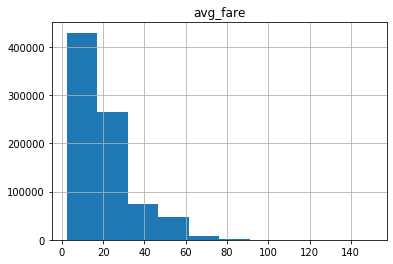

In [555]:
trip_avg_fare_DF.hist(column="avg_fare", bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23848c450>]],
      dtype=object)

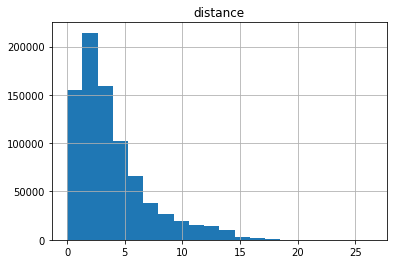

In [556]:
trip_avg_fare_DF.hist(column="distance", bins=20)

In [557]:
## Need to drop the following columns when doing training & testing
## 1. pickup_location_ID
## 2. dropoff_location_ID
## 3. pickup_date
## 4. avg_fare as this is the target

In [558]:
# ## Construct 1-hot vectors for pickup and dropoff locations
# ## There are 265 unique location IDs
# location_IDs = [i for i in range(1, 266)]

In [559]:
# trip_avg_fare_DF['pickup_location_ID'] = trip_avg_fare_DF['pickup_location_ID'].astype(CategoricalDtype(location_IDs))
# trip_avg_fare_DF['dropoff_location_ID'] = trip_avg_fare_DF['dropoff_location_ID'].astype(CategoricalDtype(location_IDs))
# trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['pickup_location_ID'], prefix='PU_ID')], axis=1)
# trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['dropoff_location_ID'], prefix='DO_ID')], axis=1)

In [560]:
# rearrange columns
cols = trip_avg_fare_DF.columns.tolist()
cols = [
 'pickup_location_ID',
 'dropoff_location_ID',
 'pickup_date',
 'avg_fare',
 'PU_time_2AM-5:59AM',
 'PU_time_6AM-9:59AM',
 'PU_time_10AM-1:59PM',
 'PU_time_2PM-5:59PM',
 'PU_time_6PM-9:59PM',
 'PU_time_10PM-1:59AM',
 'weekend/holiday',
 'PU_longitude',
 'PU_latitude',
 'DO_longitude',
 'DO_latitude',
 'distance'
]
trip_avg_fare_DF = trip_avg_fare_DF[cols]

In [561]:
agg_fare_path = path + '_avg_fare'
trip_avg_fare_DF.to_csv('./agg_taxi_fare_data/' + agg_fare_path + '.csv') 

In [562]:
trip_avg_fare_DF.shape

(828293, 16)

In [563]:
os.system("printf '\a'")

0